Amélioration du SNR : 8.84 dB
Énergie de l'audio brut : 6479.76
Énergie de l'audio débruité : 4596.08


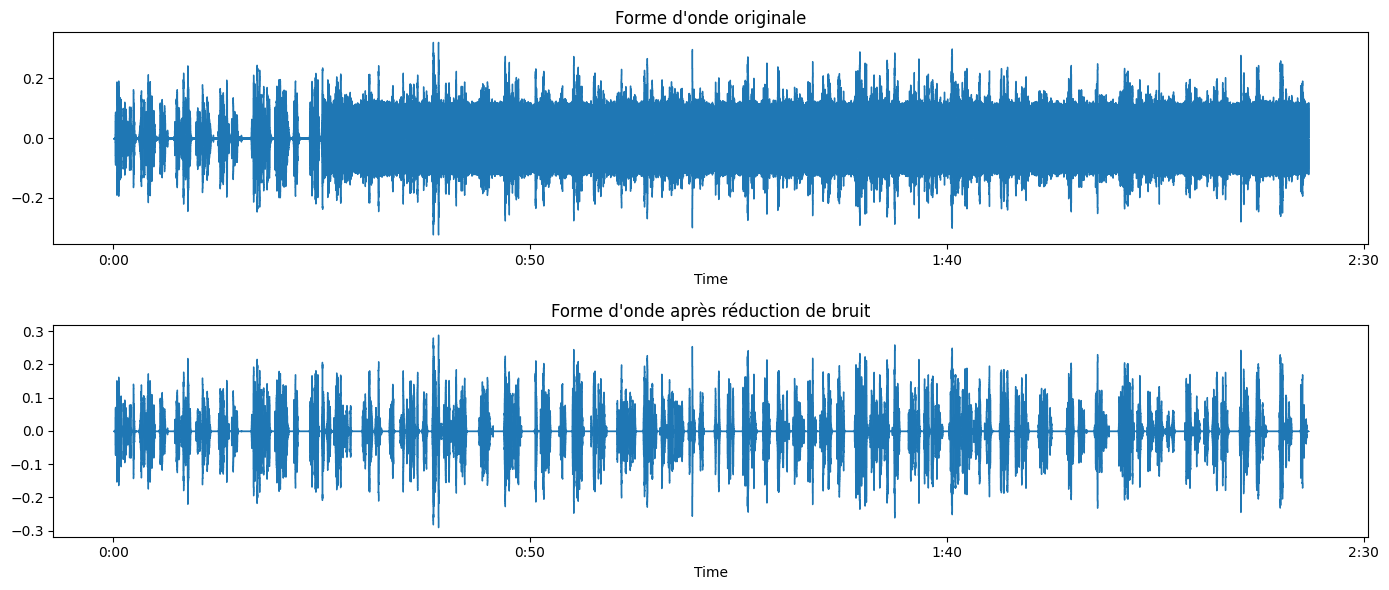

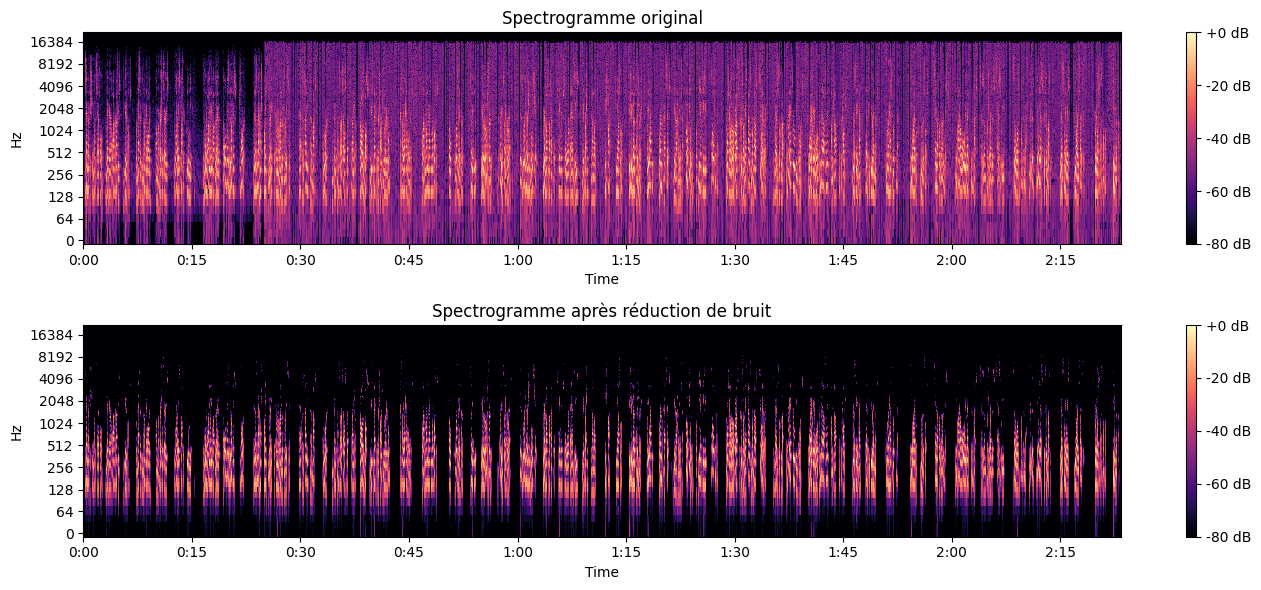

In [1]:
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# Récupérer le répertoire courant
CURRENT_DIRECTORY = os.getcwd()

class AudioDenoiser:
    def __init__(self, file_path):
        self.file_path = file_path
        self.audio = None
        self.sr = None
        self.stft_matrix = None
        self.magnitude = None
        self.phase = None
        self.denoised_audio = None

    def load_audio(self):
        """Charge un fichier audio et initialise le signal et la fréquence d'échantillonnage."""
        self.audio, self.sr = librosa.load(self.file_path, sr=None)

    def compute_stft(self):
        """Calcule la transformée de Fourier à court terme (STFT) du signal audio."""
        self.stft_matrix = librosa.stft(self.audio)
        self.magnitude = np.abs(self.stft_matrix)
        self.phase = np.angle(self.stft_matrix)

    def reduce_noise(self, noise_threshold_ratio=0.02):
        """Applique une réduction de bruit en soustrayant un seuil du spectre de magnitude."""
        noise_threshold = noise_threshold_ratio * np.max(self.magnitude)
        clean_magnitude = np.maximum(self.magnitude - noise_threshold, 0)
        self.denoised_audio = self.reconstruct_audio(clean_magnitude)

    def reconstruct_audio(self, clean_magnitude):
        """Reconstruit le signal audio à partir de la magnitude nettoyée et de la phase originale."""
        clean_stft_matrix = clean_magnitude * np.exp(1j * self.phase)
        return librosa.istft(clean_stft_matrix)

    def calculate_energy(self, audio):
        """Calcule l'énergie totale d'un signal audio."""
        return np.sum(audio**2)

    def calculate_snr(self):
        """Calcule l'amélioration du rapport signal sur bruit (SNR) après réduction de bruit."""
        noise = self.audio - self.denoised_audio
        signal_power = np.sum(self.denoised_audio**2)
        noise_power = np.sum(noise**2)
        return 10 * np.log10(signal_power / noise_power)

    def save_denoised_audio(self, output_path=f"{CURRENT_DIRECTORY}/data/cleaned_audio_stft.wav"):
        """Enregistre l'audio débruité dans un fichier."""
        sf.write(output_path, self.denoised_audio, self.sr)

    def plot_waveforms(self):
        """Affiche les formes d'onde de l'audio original et de l'audio débruité."""
        plt.figure(figsize=(14, 6))
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(self.audio, sr=self.sr)
        plt.title("Forme d'onde originale")
        plt.subplot(2, 1, 2)
        librosa.display.waveshow(self.denoised_audio, sr=self.sr)
        plt.title("Forme d'onde après réduction de bruit")
        plt.tight_layout()
        plt.show()

    def plot_spectrograms(self):
        """Affiche les spectrogrammes de l'audio original et de l'audio débruité."""
        plt.figure(figsize=(14, 6))
        plt.subplot(2, 1, 1)
        D_original = librosa.amplitude_to_db(np.abs(librosa.stft(self.audio)), ref=np.max)
        librosa.display.specshow(D_original, sr=self.sr, x_axis='time', y_axis='log')
        plt.title("Spectrogramme original")
        plt.colorbar(format='%+2.0f dB')
        plt.subplot(2, 1, 2)
        D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(self.denoised_audio)), ref=np.max)
        librosa.display.specshow(D_denoised, sr=self.sr, x_axis='time', y_axis='log')
        plt.title("Spectrogramme après réduction de bruit")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    def process(self):
        """Traite l'audio en réduisant le bruit et en affichant les résultats."""
        self.load_audio()
        self.compute_stft()
        self.reduce_noise()
        self.save_denoised_audio()
        original_energy = self.calculate_energy(self.audio)
        denoised_energy = self.calculate_energy(self.denoised_audio)
        snr_improvement = self.calculate_snr()

        print(f"Amélioration du SNR : {snr_improvement:.2f} dB")
        print(f"Énergie de l'audio brut : {original_energy:.2f}")
        print(f"Énergie de l'audio débruité : {denoised_energy:.2f}")

        self.plot_waveforms()
        self.plot_spectrograms()

if __name__ == "__main__":
    audio_path = f"{CURRENT_DIRECTORY}/data/radiobruite.wav"
    denoiser = AudioDenoiser(audio_path)
    denoiser.process()
